Задание 1: Анализ финансовых транзакций и клиентов.

Описание:

В тестовом задании вам предоставляются два набора данных:
~~~~~~
Файл transactions_data.xlsx (данные о финансовых транзакциях)

•	transaction_id – уникальный идентификатор транзакции
•	client_id – идентификатор клиента, совершившего транзакцию
•	transaction_date – дата проведения транзакции
•	service – тип оказанной финансовой услуги
•	amount – сумма транзакции (выручка)
•	payment_method – способ оплаты (банковский перевод, кредитная карта и т. д.)
•	city – город, в котором была совершена транзакция
•	consultant – имя финансового консультанта, оформившего транзакцию

Файл clients_data.json (данные о клиентах):

•	client_id – уникальный идентификатор клиента
•	age – возраст клиента
•	gender – пол клиента
•	net_worth – чистая стоимость активов клиента

Данные могут содержать пропуски, ошибки (например, некорректные даты), а также аномальные значения (отрицательные суммы, несуществующие услуги и т. д.), поэтому перед анализом необходимо их очистить и нормализовать.

Задачи:

1.	Очистка и подготовка данных. Проверить данные на пропущенные и аномальные значения (например, отрицательные суммы транзакций). Удалить или исправить некорректные данные. Привести формат дат к единому стандарту.

In [119]:
import pandas as pd
import matplotlib.pyplot as plt #Добавление библиотеки визуализации matplotlib, модуль pyplot.

In [6]:
#Чтение файлов:
df1T = pd.read_excel('Источники/Транзакции/transactions_data.xlsx')
df2C = pd.read_json('Источники/Клиенты/clients_data.json')  

In [7]:
#Проверки на дубли:
df1T.duplicated().sum()
df2C.duplicated().sum()

np.int64(0)

In [8]:
#Проверка на пустые значения:
df1T.isna().sum() #Проверка на Пустые значения в Транзакциях. 

#UPD1: Значения по 0 должно быть, после очистки. 
#UPD2: Есть данные где остальные присутствуют, но нет дат. Заполенено "INVALID_DATE".
#UPD3: Удалил данные с заменной INVALID_DATE на Nan. 

transaction_id      0
client_id           0
transaction_date    0
service             0
amount              0
payment_method      0
city                0
consultant          0
dtype: int64

In [9]:
#Проверка на пустые значения:
df2C.isna().sum() #Проверка на Пустые значения в Клиентах.

id              0
age             0
gender       2863
net_worth       0
dtype: int64

План очистки данных файла Транзакции:

Удалю данные: 
~~~
-Где нет id транзакции. Нет указаний, в тестовом задании, что с ним делать. И пока нет возможности спросить как откуда до грузить id. 
-Где нет id клиента в файле транзакции. Тоже самое.
-Где есть поле "Неизвестная услуга". Тоже самое. 
-Где нет в поле "transaction_date" даты. Пока под вопросомю.

UPD1: И ещё есть формат где даты нет, но остальные данные на месте. По итогу оставили данные где нет дат, но остальные данные есть. 

UPD2:Пока не трогаю данные где есть "Неизвестный консультант" и city - "Неизвестный город"

UPD3:Удалил данные где пропуск дат, возможно буду мешать прогнозированию.

UPD4:Удалил данные где city - "Неизвестный город". Имеет незначительные суммы. 

In [10]:
#Очистка данных на пустые значения файла Транзакции:
df1T = df1T.dropna() 

#Провоерка выше.

In [11]:
#Сохранение данных:
df1T.to_excel('Источники/Транзакции/transactions_data.xlsx', index=False)

In [12]:
#Замена INVALID_DATE на Nan
#Конвертация в тип данных datetime.

df1T['transaction_date'] = pd.to_datetime(df1T['transaction_date'], errors='coerce')

#Дает ошибку, если за ранее не изменнить.
#"Unknown datetime string format, unable to parse: INVALID_DATE, at position 15".

In [13]:
#Преобразование дат к одному в формату:
df1T['transaction_date'] = pd.to_datetime(df1T['transaction_date'])
#Приведение всех дат к одному формату с точностью до секунд:
df1T['transaction_date'] = df1T['transaction_date'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [14]:
#Сохранение данных:
df1T.to_excel('Источники/Транзакции/transactions_data.xlsx', index=False)

Есть файлы где нет даты, но остальные в норме. Продолжим удаление, но по условиям. 
*Открыл вручуную файл Excel.*. 

In [15]:
#Очистка данных на пустые значения файла Транзакции:
df1T = df1T.dropna() 

#Пересмотрел план, удаляю данные где нет даты. Так как, возможно, будет мешать прогнозированию.

In [16]:
#Удаление строк с "Неизвестной услугой":
df1T = df1T[df1T['service'] != 'Неизвестная услуга']

In [17]:
#Удаление строк с "Неизвестный город":
df1T = df1T[df1T['city'] != 'Неизвестный город'] 

In [18]:
#Сохранение данных:
df1T.to_excel('Источники/Транзакции/transactions_data.xlsx', index=False)

In [19]:
#Продолжаем очистку, теперь зайдем со стороны аномальных значений:
#Использую "Межквартильный размах" (IQR). 

# Рассчитываем первый и третий квартели, чтобы посчитать IQR.
Q1 = df1T['amount'].quantile(0.25)
Q3 = df1T['amount'].quantile(0.75)

#Расчитываем IQR:
IQR = Q3 - Q1

#Устанавливаем границы 
lower_bound = max(0, Q1 - 1.5 * IQR) #Нижняя. Нижняя не может быть меньше 0. (...отрицательные суммы).
upper_bound = Q3 + 1.5 * IQR #Верхняя.

#Вывод границ: 
print(lower_bound)
print(upper_bound)

0
144672.8060589068


In [20]:
#Вывод аномальных значений из файла:
anomal = df1T[(df1T['amount'] < lower_bound) | (df1T['amount'] > upper_bound)]
print(anomal[['service','amount']])

Empty DataFrame
Columns: [service, amount]
Index: []


In [21]:
#Удаление аномальных значений: 
df1T = df1T[(df1T['amount'] >= lower_bound) & (df1T['amount'] <= upper_bound)] 

In [22]:
#Сохранение данных:
df1T.to_excel('Источники/Транзакции/transactions_data.xlsx', index=False)

In [23]:
#Проверка: 
#Вывод аномальных значений из файла Транзакций:
anomal = df1T[(df1T['amount'] < lower_bound) | (df1T['amount'] > upper_bound)]

#Вывод:
print(anomal)

Empty DataFrame
Columns: [transaction_id, client_id, transaction_date, service, amount, payment_method, city, consultant]
Index: []


План очистки данных файла Клиентов:
~~~
-Удалить строки где нет id.
-Удалить строки где нет Общей суммы активов. 
-Удалить строки где нет возраста. 

*Пока не удаляю данные где нет пола, так как в задаче, вижу особо он не фигурирует, и может не влиять особо на анализ. Возможно в процессе что-то поменяю. 

In [24]:
#Очистка данных на пустые значения файла Клиентов, где нет id:
df2C = df2C.dropna(subset=['id'])

In [25]:
#Очистка данных на пустые значения файла Клиентов, где нет общей суммы активов:
df2C = df2C.dropna(subset=['net_worth'])

In [26]:
#Очистка данных на пустые значения файла Клиентов, где нет возраста:
df2C = df2C.dropna(subset=['age'])

In [27]:
#Сохранение данных:
df2C.to_json('Источники/Клиенты/clients_data.json', index=False)

In [28]:
#Проверка на аномальные значения капитала, отрицательные значения:
munuscap = df2C[df2C['net_worth'] < 0] #Проверим сначала, есть ли отрицательные значения. 
print(munuscap[['id', 'net_worth']])

Empty DataFrame
Columns: [id, net_worth]
Index: []


In [29]:
#Теперь зайдем со стороны "Межквартильный размах" (IQR):

# Рассчитываем первый и третий квартели, чтобы посчитать IQR.
Q1C = df2C['net_worth'].quantile(0.25)
Q3C = df2C['net_worth'].quantile(0.75)

#Расчитываем IQR:
IQR_C = Q3C - Q1C

#Устанавливаем границы 
lower_boundC = max(0, Q1C - 1.5 * IQR_C) #Нижняя. Нижняя не может быть меньше 0. (...отрицательные суммы).
upper_boundC = Q3C + 1.5 * IQR_C #Верхняя.

#Вывод границ: 
print(lower_boundC)
print(upper_boundC)


0
7400150.275


In [30]:
#Проверка: 
#Вывод аномальных значений из файла Клиентов:
anomalC = df2C[(df2C['net_worth'] < lower_boundC) | (df2C['net_worth'] > upper_boundC)]

#Вывод:
print(anomalC)

Empty DataFrame
Columns: [id, age, gender, net_worth]
Index: []


In [31]:
#Сохранение данных:
df2C.to_json('Источники/Клиенты/clients_data.json', index=False)

Закончили очистку. Далее. 

Задачи:  

2.  Анализ данных.
~~~
-Определить топ-5 наиболее популярных услуг по количеству заказов. 
-Рассчитать среднюю сумму транзакций по каждому городу. 
-Определить услугу с наибольшей выручкой (по сумме amount). 
-Вычислить процент транзакций по способам оплаты (наличные, банковский перевод и т. д.). 
-Рассчитать выручку за последний месяц (по сумме amount).

In [32]:
#Топ-5 наиболее популярных услуг по количеству заказов:
TOP_5 = df1T.groupby('service').size().nlargest(5)

print(TOP_5)

#.groupby - группировка. 
#.nlargest - возвращает самые большие значения из серии. 
#.size подсчет по колонке. 

service
Инвестиционное консультирование    1853
Управление активами                1501
Финансовое планирование            1152
Структурирование капитала          1137
Налоговое планирование             1135
dtype: int64


In [33]:
#Cредняя сумма транзакции по каждому городу:
AVGcity = df1T.groupby('city')['amount'].mean().sort_values(ascending=False)

print(AVGcity)

#.groupby - группировка.
#.mean - среднее значение.
#.sort_values - cортировка. Возрастание или убывание. (True/False).

city
Michellehaven         53857.630148
Port Michellemouth    52526.358695
East Rachelmouth      52267.155404
New Tommyborough      51694.384402
North Lauriebury      51565.637733
Kaneburgh             50241.246293
Krystalland           50225.474339
New Zacharyport       49958.015951
North Melissaland     49833.214548
Lake Tina             49697.144878
North Emily           49532.672195
South Andrew          48945.780478
Erichaven             48445.104384
Patelbury             48397.268726
Trevinoberg           48088.369661
Mayoberg              47611.356990
Harrisberg            47599.901371
Port James            47547.353263
Dannyburgh            47461.758972
Port Jordan           47405.488841
Hamiltontown          47324.161695
West Meredithhaven    47277.012122
Bondstad              47174.092961
Davidsonborough       47170.088036
East Matthewmouth     46990.980835
Johnsonfort           46713.260789
East Melissaville     46648.216060
New Chelseaberg       46213.003047
Ibarramouth    

In [34]:
#Услуга с наибольшей выручкой:
RevenueService = df1T.groupby('service')['amount'].sum().nlargest(1)

print(RevenueService)
#.groupby - группировка. 
#.nlargest - возвращает самые большие значения из серии. 
#.sum cчитает выручку, по группировке. 

service
Инвестиционное консультирование    8.836130e+07
Name: amount, dtype: float64


In [35]:
#Процент транзакций по способам оплаты (наличные, банковский перевод и т. д.):
ProcentT = df1T['payment_method'].value_counts(normalize=True) * 100

print(ProcentT)
#.value_counts - подсчет сколько раз встречается метод оплаты.
#normalize=True - раздление на доли от общего числа. * 100, превращение в проценты. 

payment_method
Кредитная карта       39.849513
Банковский перевод    34.774270
Неизвестно            10.165240
Наличные               9.884922
Криптовалюта           5.326055
Name: proportion, dtype: float64


In [36]:
#Принудительная замена на тип данных datetime:
df1T['transaction_date'] = pd.to_datetime(df1T['transaction_date'], errors='coerce')

In [37]:
#Сохранение данных:
df1T.to_excel('Источники/Транзакции/transactions_data.xlsx', index=False)

In [38]:
#Выручка за последний месяц:
last_month = df1T['transaction_date'].max().to_period('M')
#Фильтруем строки, чтобы вывести данные за последний месяц, получить данные в переменной, последний месяца: 
df1T_last_month = df1T[df1T['transaction_date'].dt.to_period('M') == last_month]
#Подсчет:
last_monthRevenue = df1T_last_month['amount'].sum()

print(f"Выручка за последний месяц: {last_monthRevenue}")
#.max - получение последнего месяца. В данных. 
#.to_period - получения месяца из даты. ('M') M в скобках дает месяц. 
#.dt - извлечение месяца из периода.
#.sum - сумма. 

Выручка за последний месяц: 78173316.70737548


Закончили расчеты. Далее. 

Задачи:

3. Объединить данные(и анализ): 
~~~
-Объединить транзакции с клиентскими данными (по id).
-Создать новую колонку с уровнями активов.
-Провести анализ по уровням активов и определить, какие категории клиентов приносят наибольшую выручку.

Категории клиентов по уровню активов:
a.	Низкий капитал (<100 000).
b.	Средний капитал (100 000 - 1 000 000).
c.	Высокий капитал (>1 000 000).  

In [39]:
#Join файлов:
merged_df = pd.merge(df1T, df2C, left_on='client_id', right_on='id', how='inner')

#Проверка: 
print(merged_df.head(1))

#.merge - это join, если на языке SQL. 
#left_on/Right_on - говорим Pandas: колонка client_id слева, колонка id, справа. 
#Используем если разные название id.
#how='inner' - тип соединения. Соединяемся только по совпавшим id, в двух файлах. 
#Pandas проверяет есть ли совпавшие слева, и соединяет со совпавшими справа. 

                         transaction_id                             client_id  \
0  ff36597c-df41-44a0-9f46-6aa1fe615270  1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7   

     transaction_date                    service        amount  \
0 2025-01-04 00:02:20  Структурирование капитала  55838.059789   

       payment_method               city     consultant  \
0  Банковский перевод  North Patrickport  Cheryl Waller   

                                     id  age   gender   net_worth  
0  1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7   41  Мужчина  2514729.46  


In [58]:
#Колонка с уровнями активов:

#Функция для уровней активов:
def ActivClients(x):
    if x < 100000:
        return 'Низкий капитал'
    elif 100000 <= x <= 1000000:
        return 'Средний капитал'
    elif x > 1000000:
        return 'Высокий капитал'
    else:
        'Неопределено'

#Cоздание колонки с уровнями активов:
merged_df['levelClients_Activ'] = merged_df['net_worth'].apply(ActivClients) 

#Проверка: 
print(merged_df[['net_worth','levelClients_Activ']].head(5))

#def объявление функции(ActivClients).
#if - условие. 
#elif - доп.условие. 
#else - вывод, если не под, что не подходит. 
#apply - метод, который позволяет применить функцию ко всем элементам в столбце(или строке) таблицы.
#return - ключевое слово, которое используется внутри, для возврата значении функции. 
#*После объединения использовали новый DataFrame.

    net_worth levelClients_Activ
0  2514729.46    Высокий капитал
1   566568.29    Средний капитал
2  1896001.28    Высокий капитал
3  4865849.92    Высокий капитал
4  3992281.84    Высокий капитал


In [62]:
#Категории клиентов приносящие наибольшую выручку, анализ по уровням активов:
RevenueTOPgroupActivClients = merged_df.groupby('levelClients_Activ')['amount'].sum().sort_values(ascending=False).reset_index()

print(RevenueTOPgroupActivClients)
#.groupby - группировка. 
#.sum - Сумма выручки по группам. 
#.sort_values(ascending=False) - Сортировка по убыванию. False. От большего к меньшему (True - наоборот).
#.reset_index() - превращение в "таблицу" (Убрали, Name: amount, dtype: float64, появились номера строк).

  levelClients_Activ        amount
0    Высокий капитал  2.173297e+08
1    Средний капитал  4.715384e+07
2     Низкий капитал  4.340166e+06


Закончили анализ. Далее. 

4. Визуализация данных.
~~~
-Построить распределение сумм транзакций.
-Создать диаграмму выручки по услугам.
-Построить график зависимости средней суммы транзакции от возраста клиентов.

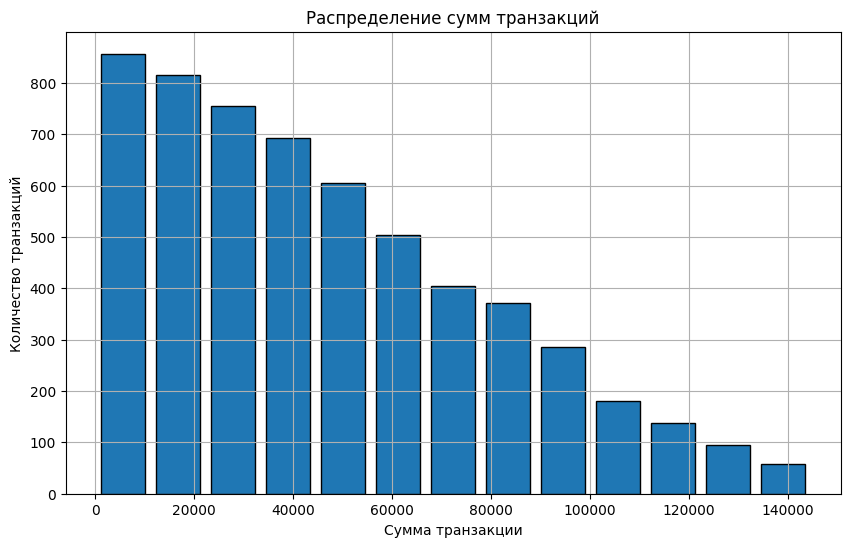

In [129]:
#Распределение сумм транзакций:

plt.figure(figsize=(10, 6))
plt.hist(merged_df['amount'], bins=bins, edgecolor='black', rwidth=0.8)
plt.title('Распределение сумм транзакций')
plt.xlabel('Сумма транзакции')
plt.ylabel('Количество транзакций')
plt.grid(True) #Сетка разделения.